In [1]:
import PyQt5
get_ipython().magic('matplotlib qt')

In [2]:
from tqdm import tqdm
from tqdm import tqdm_notebook
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
from matplotlib import style;  style.use('ggplot')
from sklearn.datasets.samples_generator import make_blobs

In [3]:
import lonely_boy2 as lb2

In [23]:
X, y = make_blobs(n_samples=943, centers=3, n_features=25)

In [24]:
plt.scatter(X[:,0], X[:,1])
plt.show()

In [8]:
colors = 10*['g', 'c', 'b', 'k']

In [3]:
class BSAS:
    def __init__(self, theta=None, q=None):
        # theta: Dissimarity Threshold
        # q: Max #Clusters
        self.theta = theta; self.q = q
        self.clusters = {}; self.centroids = {}
        
    def __getCentroid(self, X, Y):
        try:
            probe = Y[1]
            return np.divide(X, Y[0])
        except:
            return X
    
    def __findClosestCluster(self, clusters, centroids, sample):
        centID = 0
        cluster_population = clusters[centID].shape
        centroid = self.__getCentroid(centroids[centID], cluster_population)
#         try:
#             centroid = np.divide(centroids[centID], cluster_population[1])
#         except:
#             centroid = centroids[centID]
        minDist = euclidean(centroid, sample)
        try:
            for cntID in centroids:
                if (cntID == 0):
                    continue
                cluster_population = clusters[cntID].shape
                centroid = self.__getCentroid(centroids[cntID], cluster_population)
#                 centroid = np.divide(centroids[cntID], cluster_population)
                tmp = euclidean(centroid, sample)
                if (tmp < minDist):
                    minDist = tmp
                    centID = cntID
        except:
            pass
        return minDist, centID
    
    def __getEuclideanDistances(self, data, size):
        minED = np.inf; maxED = -np.inf
        
        for column_i in tqdm_notebook(range(size), desc='Computing (Min/Max) Euclidean Distances...'):                
            for column_j in range(size):
                if (column_i == column_j):
                    continue
                dist = euclidean(data[:,column_i], data[:,column_j])
                if (dist < minED):
                    minED = dist
                if (dist > maxED):
                    maxED = dist
                    
        return minED, maxED
    
    def __findIndexofMax(self, dct):
        minVal = np.inf       
        minKey = None
        for key in dct:
            tmp = dct[key]
            if (tmp < minVal):
                minVal = tmp
                minKey = key
        return minKey
    
    def __findOptimalCluster(self, clusters):
        clusters_frq = {}
        min_cluster = np.min(clusters)
        for cluster in tqdm_notebook(clusters, desc='Finding Optimal Cluster...'):
            if (cluster == min_cluster):
                continue
            try:
                clusters_frq[cluster] += 1
            except:
                clusters_frq[cluster] = 1
        opt_cluster = None; frq_opt_cluster = -np.inf
        
        for key in clusters_frq:
            tmp = clusters_frq[key]
            if (tmp > frq_opt_cluster):
                frq_opt_cluster = tmp
                opt_cluster = key
        return opt_cluster
#         min_cluster = np.inf
#         min_cluster2 = np.inf
#         for cluster in tqdm_notebook(clusters, desc='Finding Optimal Cluster...'):
#             if (cluster < min_cluster2 and cluster != min_cluster):
#                 if(cluster < min_cluster):
#                     min_cluster2 = min_cluster
#                     min_cluster = cluster
#                 else:
#                     min_cluster2 = cluster
#         return min_cluster2
    ''' 
        TO-DO--Restructure Algorithm With the following idea:
        find the longest step which gives the number of clusters 
        that are not equal to the minimum number of clusters.
    '''
    def __findOptimalTheta(self, opt_cluster, clusters, theta):
        cl_start = 0; cl_fin = 0; cl_key = None
        found = False
        cl_ranges = {}
        
        for i in range(len(clusters)):
            if (clusters[i] == opt_cluster):
                if (not found):
                    cl_start = i
                    cl_fin = i
                    found = True
                else:
                    cl_fin += 1
            else:
                if (found):
                    tmp = [cl_start, cl_fin, (cl_fin-cl_start)]
                    cl_ranges[i] = tmp
        
        for key in cl_ranges:
            max_range = -np.inf
            val = cl_ranges[key][2]
            if (val > max_range):
                max_range = val
                cl_key = key
        
        opt_theta_range = cl_ranges[cl_key]
        theta_avg = 0
        for i in range(opt_theta_range[0], opt_theta_range[1]+1):
            theta_avg += theta[i]
        
        theta_avg = theta_avg / (opt_theta_range[1] - opt_theta_range[0] + 1)
        return theta_avg                          
            
        
    def fit(self, data, order):
        m = 1 #Clusters/Centroids
        clusters = {}; centroids = {}
        
        first_sample = data[:,order[0]]
        clusters[m-1] = first_sample; centroids[m-1] = np.add(np.zeros_like(first_sample), first_sample)
        
        N, l = data.shape
        for i in range(1,l):
            sample = data[:,order[i]]
            dist, k = self.__findClosestCluster(clusters, centroids, sample)
            if ((dist > self.theta) and (m < self.q)):
                m += 1
                clusters[m-1] = sample; centroids[m-1] = np.add(np.zeros_like(sample), sample)
            else:
                clusters[k] = np.vstack((clusters[k], sample))
                centroids[k] = np.add(centroids[k], sample)
            
        self.clusters = clusters
        self.centroids = centroids
    
    def fit_best(self, data, n_times=20, first_time=True, plot_graph=True):
        N, l = data.shape
        if (first_time):
            minDist, maxDist = self.__getEuclideanDistances(data, l)
            dists = np.save('min-max-euclidean-distances.npy', np.array([minDist, maxDist], dtype=np.float))
        else:
            minDist, maxDist = np.load('min-max-euclidean-distances.npy')

        meanDist = (minDist + maxDist)/2
        theta_min = 0.25 * meanDist; theta_max = 1.75 * meanDist
        n_theta = 50
        s = (theta_max - theta_min)/(n_theta - 1)
        
        total_clusters = []
        total_theta = np.arange(theta_min, theta_max+s, s)
        for theta in tqdm_notebook(total_theta, desc=('Running BSAS...')):
            max_clusters = -np.inf
            for i in np.arange(n_times):
                clf = BSAS(theta=theta,q=l)
                order = np.random.permutation(range(l))
                clf.fit(data, order)
                clusters, centroids = clf.predict()
                clustersN = len(clusters)
                if (clustersN > max_clusters):
                    max_clusters = clustersN
            total_clusters = total_clusters + [max_clusters]
        
        if (plot_graph==True):
            plt.plot(total_theta, total_clusters, 'b-') 
            plt.xlabel('theta')
            plt.ylabel('#clusters')
            plt.title('#clusters versus theta')
            plt.grid()
            plt.show()
        
        opt_cluster = self.__findOptimalCluster(total_clusters) #print (opt_cluster)
        opt_theta = self.__findOptimalTheta(opt_cluster, total_clusters, total_theta) #print (opt_theta)
        
        self.theta = opt_theta
        self.q = opt_cluster
        
    def predict(self):
        final_centroids = {}
        for key in self.clusters:
            final_centroids[key] = self.__getCentroid(self.centroids[key], self.clusters[key].shape)
        return self.clusters, final_centroids
    
    def specs(self):
        return self.theta, self.q

In [5]:
X = np.load('FOOKIN_df.npy')
clf = lb2.BSAS()
clf.fit_best(X.T, first_time=False, n_times=50)

Finding Optimal Cluster...: 100%|██████████████████████████████████████████████████████████████| 50/50 [00:00<?, ?it/s]


In [47]:
clf = BSAS(theta=3.5,q=5)
order = np.random.permutation(range(X.shape[0]))
clf.fit(X.T, order)

In [48]:
clusters, centroids = clf.predict()

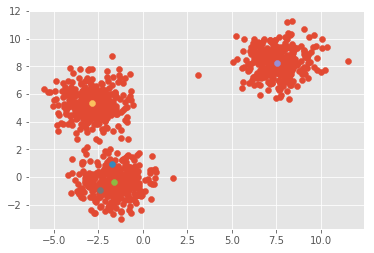

In [49]:
plt.scatter(X[:,0], X[:,1])
for key in centroids:
    centroid = centroids[key]
    plt.scatter(centroid[0], centroid[1])
plt.show()

In [ ]:
clf = BSAS()
clf.fit_best(X.T, first_time=False, n_times=50)

A Jupyter Widget

In [5]:
clf.specs()

(2.4553841752304026, 2)

In [6]:
order = np.random.permutation(range(X.shape[0]))
clf.fit(X.T, order)

theta, q = clf.specs()
print (theta, q)
clusters, centroids = clf.predict()

plt.scatter(X[:,0], X[:,1])
for key in centroids:
    centroid = centroids[key]
    plt.scatter(centroid[0], centroid[1])
plt.show()

2.45538417523 2


A Jupyter Widget

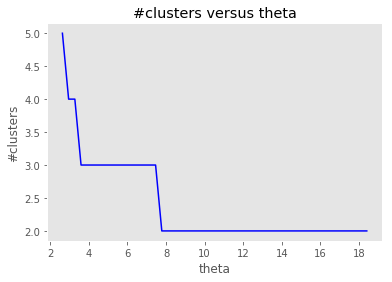

A Jupyter Widget

In [35]:
clf.fit_best(X.T, first_time=False, n_times=50)

37.0404952302 3


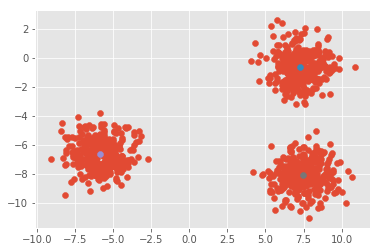

In [41]:
order = np.random.permutation(range(X.shape[0]))
clf.fit(X.T, order)

theta, q = clf.specs()
print (theta, q)
clusters, centroids = clf.predict()

plt.scatter(X[:,0], X[:,1])
for key in centroids:
    centroid = centroids[key]
    plt.scatter(centroid[0], centroid[1])
plt.show()

A Jupyter Widget

A Jupyter Widget

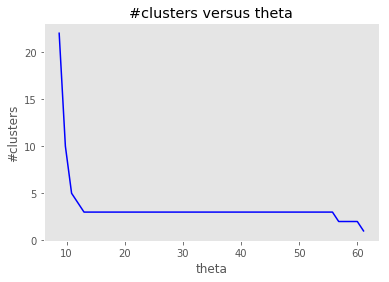

A Jupyter Widget

In [6]:
clf = BSAS()
clf.fit_best(X.T, first_time=True, n_times=50)

In [8]:
theta, q = clf.specs()

In [9]:
order = np.random.permutation(range(X.shape[0]))
clf.fit(X.T, order)

In [10]:
clf.predict()

({0: array([[ -6.89886292,  -1.71186448,   1.29290937, ...,  -5.20735125,
            9.51497382,   6.73245592],
         [ -9.13836063,  -1.12724315,   0.44672985, ...,  -5.43074427,
            9.27684301,   7.7580164 ],
         [ -0.1656704 ,  -5.0894453 ,   5.78491498, ...,  -7.39809407,
           -5.81110884,  -5.50273587],
         ..., 
         [  0.56630892,  -3.33705359,   6.81487158, ...,  -7.40793304,
           -5.6083821 ,  -6.62657134],
         [ -7.48875835,  -0.3107604 ,   0.76275779, ...,  -5.1887362 ,
            9.56226198,   9.79020682],
         [ -0.09959991,  -6.68396254,   7.13849984, ..., -10.60903801,
           -3.71796714,  -5.04577952]]),
  1: array([[ -5.21270583,  10.29740822,   1.88507051, ...,   4.53982841,
            6.25718844,  -6.78822609],
         [ -6.66107883,   9.35022672,   2.36931557, ...,   3.08617354,
            7.54911372,  -3.82159198],
         [ -6.13173931,   8.00879702,   1.14962009, ...,   2.80954947,
            6.18162402,  -